In [56]:
# Import relevant libraries and modules
# Data analysis
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
import csv
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Import retail stores dataset
retail = pd.read_csv('summer_internship_takehome.csv')
retail.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False


# I. Summary statistics and plots

Annual Profit Margin Statistics
Mean:  24.863229256707516
Median:  26.184928404393766


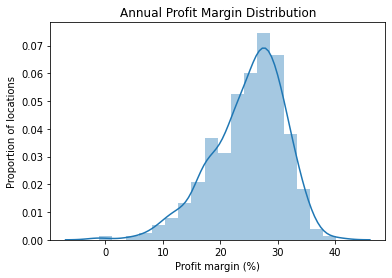

In [58]:
# Group rows by location
retail_location = retail.groupby('Location number').sum().drop(columns={'Month', 'Owned'})
retail_location['Number of products'] = [int(retail_location['Number of products'][i]/12) for i in np.arange(1, 334)]

# Create profit margin column
retail_location['Profit margin'] = ((retail_location['Gross revenue'] - 
                                   retail_location['Fixed cost'] - 
                                   retail_location['Variable cost'] - 
                                   retail_location['Rental cost']) / retail_location['Gross revenue']) * 100

# Calculate mean and median annual profit margin
print("Annual Profit Margin Statistics")
print("Mean: ", np.average(retail_location['Profit margin']))
print("Median: ", np.median(retail_location['Profit margin']))

# Visualize annual profit margin distribution
sns.distplot(retail_location['Profit margin']) # Slightly skewed to left
plt.title("Annual Profit Margin Distribution")
plt.xlabel("Profit margin (%)")
plt.ylabel("Proportion of locations");

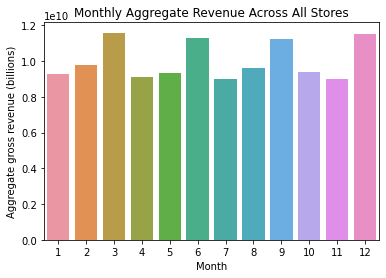

In [59]:
# Group rows by month
retail_monthly = retail.groupby('Month').sum().drop(columns={'Location number', 'Fixed cost', 'Variable cost', 'Rental cost', 'Number of products', 'Owned'})

# Visualize monthly aggregate revenue across all stores
sns.barplot(x=retail_monthly.index, y=retail_monthly['Gross revenue'])
plt.title("Monthly Aggregate Revenue Across All Stores")
plt.xlabel("Month")
plt.ylabel("Aggregate gross revenue (billions)");

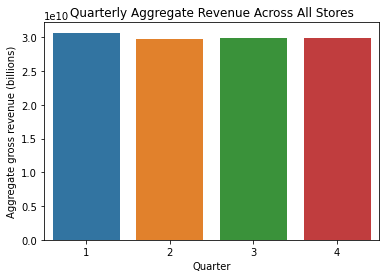

In [60]:
# Group rows by quarter
retail_quarterly = pd.DataFrame(
    data = {'Gross revenue' : [sum(retail_monthly.iloc[i:i+3, 0]) for i in np.arange(0,12,3)]}, 
    columns=['Gross revenue']
)

# Visualize quarterly aggregate revenue across all stores
sns.barplot(x=retail_quarterly.index+1, y=retail_quarterly['Gross revenue']);
plt.title("Quarterly Aggregate Revenue Across All Stores")
plt.xlabel("Quarter")
plt.ylabel("Aggregate gross revenue (billions)");

# II. Cleaning the data

I could have imputed rental costs of owned locations with a simple average of similar locations (e.g. number of products, state, etc.). Using a linear prediction model enabled me to make more informed predictions with minimally more effort.

RMSE:  843564
Avg. CV RMSE Score:  885726.1118476263
Test RMSE:  676462


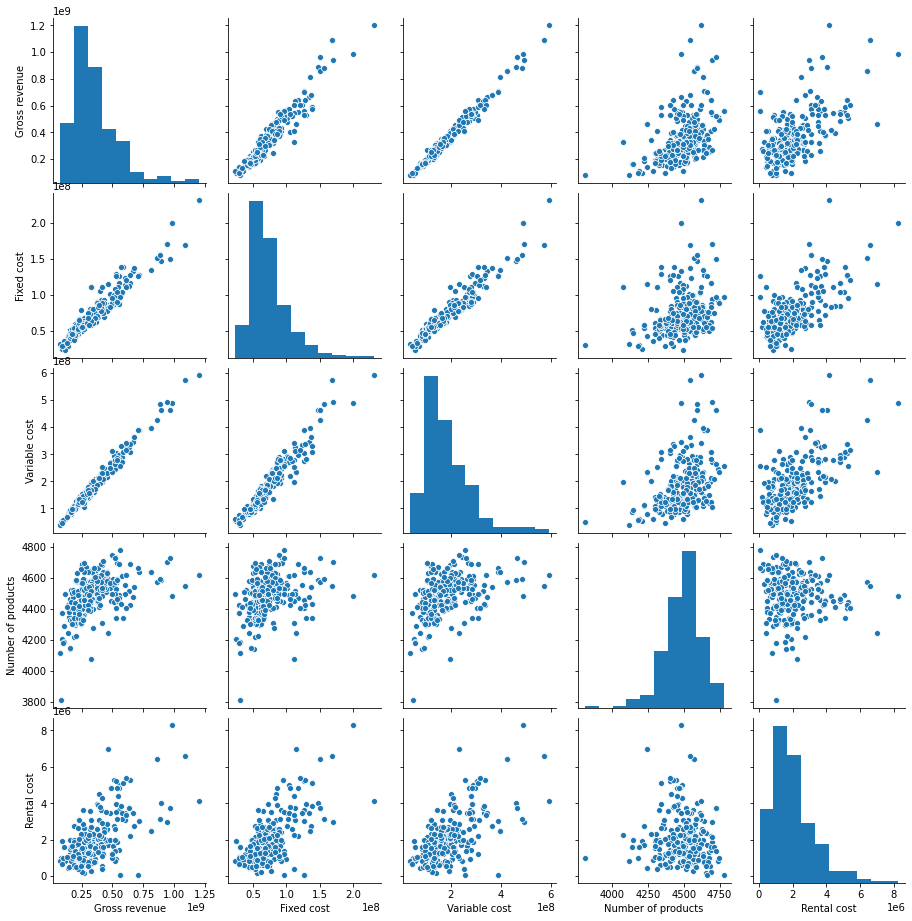

In [61]:
# Create dataset of only leased retail locations
retail_loc_leased = retail_location.loc[retail_location['Rental cost'] > 0]

# Create train test split of data when building simple models to predict Rental cost
x_train, x_test, y_train, y_test = train_test_split(retail_loc_leased[['Gross revenue', 
                                                                       'Fixed cost', 
                                                                       'Variable cost', 
                                                                       'Number of products']], 
                                                    retail_loc_leased[['Rental cost']], 
                                                    test_size = .15)
retail_loc_leased_train = x_train.copy()
retail_loc_leased_train['Rental cost'] = y_train

# Visualize correlation between features
sns.pairplot(retail_loc_leased_train);

# Define Root Mean Squared Error (RMSE) function
def rmse(model,X,Y):
    return np.sqrt(np.mean((Y-model.predict(X))**2))

# Construct simple linear prediction model
model_lr = lm.LinearRegression(fit_intercept=True)
model_lr.fit(x_train, y_train)
model_lr.predict(x_train)

# Check accuracy
print("RMSE: ", int(rmse(model_lr, x_train, y_train)))
print("Avg. CV RMSE Score: ", np.mean(cross_val_score(model_lr, x_train, y_train, scoring=rmse, cv=5)))
print("Test RMSE: ", int(rmse(model_lr, x_test, y_test)))

In [62]:
# Insert rent predictions for owned locations based on model created above
retail_loc_rent = retail_location.copy()
retail_loc_rent['Rental cost'] = [retail_loc_rent['Rental cost'][i] if retail_loc_rent['Rental cost'][i] > 0 
                                  else (model_lr.predict(retail_loc_rent.drop(columns={'Profit margin', 'Rental cost'}).iloc[[i-1]])[0][0]) for i in np.arange(1,334)]

# Recalculate profit margin column (kept as proportion for calculations)
retail_loc_rent['Profit margin'] = (((retail_loc_rent['Gross revenue'] - 
                                   retail_loc_rent['Fixed cost'] - 
                                   retail_loc_rent['Variable cost'] - 
                                   retail_loc_rent['Rental cost']) / retail_loc_rent['Gross revenue']))

retail_loc_rent.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Profit margin
Location number,,,,,,
1,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06,4452,0.275516
2,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05,4502,0.248858
3,3.317718e+08,6.429775e+07,1.848279e+08,1.097252e+06,4620,0.245798
4,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06,4481,0.208132
5,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05,4533,0.209531


# III. Quantify drivers of success

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Profit margin
Location number,,,,,,
198,-33.75%,-40.39%,-78.43%,+9.04%,+3.9%,+38.26%
233,+35.54%,+22.82%,+26.61%,-3064.78%,+5.59%,+32.37%
118,+62.62%,+49.98%,+59.21%,+46.85%,+4.55%,+31.36%
9,+55.58%,+46.56%,+50.03%,+50.25%,+5.81%,+30.57%
271,-35.47%,-43.45%,-57.8%,-77.2%,+2.72%,+29.21%


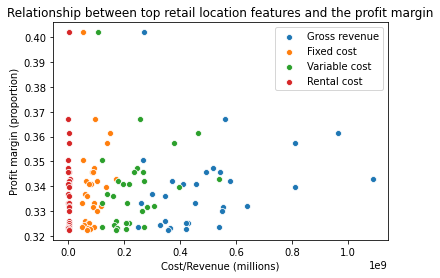

In [63]:
# Identify locations with the highest profit margins
retail_top = retail_loc_rent.sort_values(by='Profit margin', ascending=False).head(30)

# Visualize correlation between features and profit margin
feature_list = ['Gross revenue', 'Fixed cost', 'Variable cost', 'Rental cost']
for i in feature_list:
    sns.scatterplot(x=retail_top[i], y=retail_top['Profit margin'])
plt.title("Relationship between top retail location features and the profit margin")
plt.ylabel("Profit margin (proportion)")
plt.xlabel("Cost/Revenue (millions)")
plt.legend(labels=feature_list)

# Compare top retail location features to averages
feature_list.extend(['Number of products', 'Profit margin'])
for i in feature_list:
    output = []
    for x in retail_top[i]:
        if x > np.average(retail_loc_rent[i]):
            output.append('+' + (((x - np.average(retail_loc_rent[i])) / x)*100).round(2).astype(str) + '%')
        else:
            output.append((((x - np.average(retail_loc_rent[i])) / x)*100).round(2).astype(str) + '%')
    retail_top[i] = output
    
retail_top.head()